# Topical Analysis

This notebook extends the analysis done in Filippou et al. (2024) to a topical level.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

chunk_predictions = pd.read_csv("chunk_predictions.csv")
chunk_predictions = chunk_predictions.drop("Text", axis=1)
results_df = chunk_predictions

In [2]:
# Want to aggregate by month instead of quarter

# Step 1: Extract Year and Report Number
results_df["Year"] = results_df["Filename"].str.extract(r"(\d{4})").astype(int)
results_df["Report_Number"] = results_df["Filename"].str.extract(r"\((\d+)\)").astype(int)

# Step 2: Map Report Numbers to Months
    # Got months from Fed website and put them in a spreadsheet
    # See C:\Users\MCOB PHD 14\Desktop\bbFinal\Notebooks\BB_publication_months.xlsx
def get_month(year, report_number):
    # Define mappings for report numbers to months
    if 1970 <= year <= 1978:
        month_mapping = {1: "12", 2: "11", 3: "10", 4: "09", 5: "08", 6: "07", 7: "06", 8: "05", 9: "04", 
                         10: "03", 11: "02", 12: "01"}
    elif year == 1979:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "08", 5: "07", 6: "05", 7: "04", 8: "03", 9: "01"}
    elif year == 1980:
        month_mapping = {1: "12", 2: "11", 3: "10", 4: "09", 5: "08", 6: "07", 7: "05", 8: "04", 9: "03", 10: "01"}
    elif year in {1981, 2017, 2023}:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "07", 5: "05", 6: "04", 7: "03", 8: "01"}
    elif year == 2012:
        month_mapping = {1: "11", 2: "10", 3: "08", 4: "07", 5: "06", 6: "04", 7: "02", 8: "01"}
    elif year in {2018, 2020, 2024}:
        month_mapping = {1: "12", 2: "10", 3: "09", 4: "07", 5: "05", 6: "04", 7: "03", 8: "01"}
    elif year in {2002, 2003, 2005, 2006, 2007, 2011, 2016, 2019, 2022}:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "07", 5: "06", 6: "04", 7: "03", 8: "01"}
    elif year in {2004, 2008, 2009, 2010, 2013, 2014, 2015, 2021}:
        month_mapping = {1: "12", 2: "10", 3: "09", 4: "07", 5: "06", 6: "04", 7: "03", 8: "01"}
    elif year in {1988, 2001}:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "08", 5: "06", 6: "05", 7: "03", 8: "01"}
    elif year == 1983:
        month_mapping = {1: "12", 2: "11", 3: "09", 4: "08", 5: "07", 6: "05", 7: "03", 8: "02"}
    elif year in {1984, 1985, 1986, 1987, 1990, 1991, 1996, 1997}:
        month_mapping = {1: "12", 2: "10", 3: "09", 4: "08", 5: "06", 6: "05", 7: "03", 8: "01"}
    else:
        month_mapping = {1: "12", 2: "11", 3: "09", 4: "08", 5: "06", 6: "05", 7: "03", 8: "01"}
    return month_mapping.get(report_number, "Unknown")

results_df["Month"] = results_df.apply(lambda row: get_month(row["Year"], row["Report_Number"]), axis=1)

# Step 3: Convert Year and Month to Date-Time Format
results_df["DATE"] = results_df.apply(lambda row: f"{row['Year']}-{row['Month']}-01", axis=1)
results_df["DATE"] = pd.to_datetime(results_df["DATE"], errors="coerce")

# Step 4: Aggregate Data by Month
topic_columns = ["Employment", "Prices", "Consumption", "Manufacturing", "Construction",
                 "Lending", "Uncertainty", "Resources", "Transportation", "Outlook",
                 "Labor", "Capital", "Trade"]

aggregated_df = results_df.groupby("DATE")[topic_columns].sum().reset_index()

# Export to csv
#aggregated_df.to_csv("aggregated_predictions_monthly.csv", index=False)


In [3]:
df = aggregated_df
df['DATE'] = pd.to_datetime(df['DATE'])

# Create dummy variable for dates of recessions
    # Dates defined by Business Cycle Dating Committee of the NBER
df["Recession"] = 0
df.loc[(df["DATE"] >= "1969-12-01") & (df["DATE"] <= "1970-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1973-11-01") & (df["DATE"] <= "1975-03-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1980-01-01") & (df["DATE"] <= "1980-06-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1981-07-01") & (df["DATE"] <= "1982-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1990-07-01") & (df["DATE"] <= "1991-03-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2001-03-01") & (df["DATE"] <= "2001-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2007-12-01") & (df["DATE"] <= "2009-06-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2020-02-01") & (df["DATE"] <= "2020-04-01"), "Recession"] = 1

# Topic columns
topic_columns = ["Employment", "Prices", "Consumption", "Manufacturing", "Construction",
                 "Lending", "Uncertainty", "Resources", "Transportation", "Outlook",
                 "Labor", "Capital", "Trade"]


In [4]:
# Create z-scores for each topic and save over the existing columns
for topic in topic_columns:
    df[topic] = (df[topic] - df[topic].mean()) / df[topic].std()

# Using topical counts to forecast recessions

In [5]:
# This is the same approach as Table 1, column 4 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment
# Logit model where 1 = economy in a recession, as defined by NBER

import statsmodels.api as sm

# Drop rows with missing values
df = df.dropna()

# Define X as including all the topic columns
X = df[topic_columns]
X = sm.add_constant(X)
y = df['Recession']

# Fit a logit model
model = sm.Logit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.206679
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Recession   No. Observations:                  470
Model:                          Logit   Df Residuals:                      456
Method:                           MLE   Df Model:                           13
Date:                Fri, 29 Nov 2024   Pseudo R-squ.:                  0.4906
Time:                        21:19:58   Log-Likelihood:                -97.139
converged:                       True   LL-Null:                       -190.70
Covariance Type:            nonrobust   LLR p-value:                 5.979e-33
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.4094      0.343     -9.951      0.000      -4.081      -2.738
Employment         1.6022      0.305      5.259      0.000       1.005       2.199
Prices             1.3682      0.362      3.776      0.000       0.658       2.078
Consumption        0.0243      0.308      0.079      0.937      -0.578       0.627
Manufacturing      0.3331      0.280      1.188      0.235      -0.217       0.883
Construction       0.6917      0.281      2.463      0.014       0.141       1.242
Lending           -0.0455      0.256     -0.177      0.859      -0.548       0.457
Uncertainty       -1.4774      0.452     -3.272      0.001      -2.362      -0.592
Resources          0.6342      0.182      3.490      0.000       0.278       0.990
Transportation    -1.2485      0.513     -2.432      0.015      -2.255      -0.242
Outlook            0.8443      0.282      2.996      0.003       0.292       1.397
Labor              0.1948      0.381      0.512      0.609      -0.551       0.941
Capital            0.5672      0.226      2.511      0.012       0.124       1.010
Trade              0.8181      0.298      2.743      0.006       0.234       1.403
==================================================================================
"""

In [6]:
# Test for multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 1: Prepare the independent variables (X)
X = df[topic_columns]
X = sm.add_constant(X)

# Step 2: Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF results
vif_data

,Variable,VIF
0,const,1.000000
1,Employment,2.606081
2,Prices,2.682632
3,Consumption,2.178395
4,Manufacturing,3.004183
5,Construction,1.839953
6,Lending,1.939451
7,Uncertainty,1.867227
8,Resources,1.114451
9,Transportation,2.861658


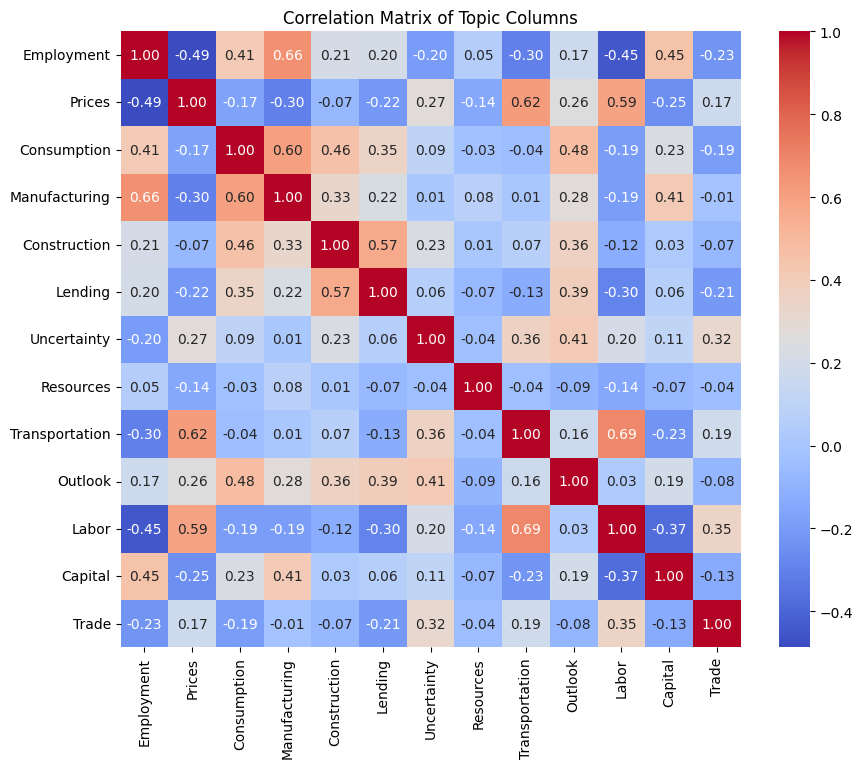

,Employment,Prices,Consumption,Manufacturing,Construction,Lending,Uncertainty,Resources,Transportation,Outlook,Labor,Capital,Trade
Employment,1.000000,-0.487205,0.413145,0.657512,0.209378,0.198442,-0.200772,0.053737,-0.302349,0.172941,-0.448351,0.449273,-0.227393
Prices,-0.487205,1.000000,-0.169004,-0.303684,-0.074307,-0.218720,0.274651,-0.144770,0.620716,0.261538,0.593078,-0.252685,0.174839
Consumption,0.413145,-0.169004,1.000000,0.600256,0.458617,0.348583,0.093863,-0.025878,-0.039937,0.478456,-0.192675,0.230215,-0.191631
Manufacturing,0.657512,-0.303684,0.600256,1.000000,0.325490,0.222963,0.012806,0.079903,0.009829,0.279605,-0.193671,0.409471,-0.011375
Construction,0.209378,-0.074307,0.458617,0.325490,1.000000,0.565992,0.231629,0.005862,0.067258,0.363527,-0.124706,0.026237,-0.071682
Lending,0.198442,-0.218720,0.348583,0.222963,0.565992,1.000000,0.061187,-0.067833,-0.130726,0.388826,-0.295455,0.060895,-0.210239
Uncertainty,-0.200772,0.274651,0.093863,0.012806,0.231629,0.061187,1.000000,-0.036063,0.360018,0.412081,0.204361,0.109370,0.319740
Resources,0.053737,-0.144770,-0.025878,0.079903,0.005862,-0.067833,-0.036063,1.000000,-0.038038,-0.088799,-0.144837,-0.069580,-0.044991
Transportation,-0.302349,0.620716,-0.039937,0.009829,0.067258,-0.130726,0.360018,-0.038038,1.000000,0.164783,0.687294,-0.227230,0.186534
Outlook,0.172941,0.261538,0.478456,0.279605,0.363527,0.388826,0.412081,-0.088799,0.164783,1.000000,0.033017,0.193981,-0.084524


In [7]:
# Correlation matrix of topic columns
corr = df[topic_columns].corr()

# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Topic Columns")
plt.show()

corr

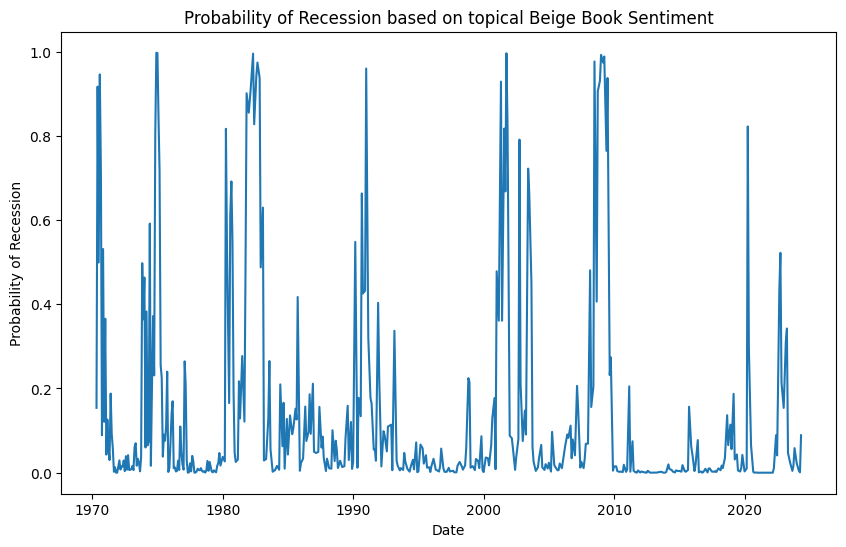

In [8]:
# This recreates Figure 2 from Filippou et al. (2024)
    # Clearly, sentiment from Beige Books is useful for predicting recessions

# Calculate probabilities from the logit model above
df['Recession_probability'] = model.predict(X)

# Plot the probabilities
plt.figure(figsize=(10, 6))
plt.plot(df['DATE'], df['Recession_probability'])
plt.xlabel('Date')
plt.ylabel('Probability of Recession')
plt.title('Probability of Recession based on topical Beige Book Sentiment')
plt.show()


# Lags of topical sentiment to predict recessions

This follows Filippou et al., 2024

In [9]:
# Create lags of dependent variable

# Create a three-month lead of the Recession dummy variable
df['Recession_lead_3'] = df['Recession'].shift(3)

# Create a six-month lead of the Recession dummy variable
df['Recession_lead_6'] = df['Recession'].shift(6)

# Create a three-month lag of the Recession dummy variable
df['Recession_lag_3'] = df['Recession'].shift(-3)

# Create a six-month lag of the Recession dummy variable
df['Recession_lag_6'] = df['Recession'].shift(-6)

In [10]:
# This is the same approach as Table 1, column 2 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment

# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the six-month lag of the Recession dummy variable
y = dfBinary['Recession_lag_6']

# Fit the model with a logistic regression
model = sm.Logit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.313367
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        Recession_lag_6   No. Observations:                  458
Model:                          Logit   Df Residuals:                      444
Method:                           MLE   Df Model:                           13
Date:                Fri, 29 Nov 2024   Pseudo R-squ.:                  0.1842
Time:                        21:21:22   Log-Likelihood:                -143.52
converged:                       True   LL-Null:                       -175.94
Covariance Type:            nonrobust   LLR p-value:                 7.086e-09
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.5716      0.223    -11.513      0.000      -3.009      -2.134
Employment        -0.8772      0.283     -3.097      0.002      -1.432      -0.322
Prices             0.7009      0.273      2.570      0.010       0.166       1.235
Consumption        0.3419      0.234      1.459      0.145      -0.117       0.801
Manufacturing      0.3707      0.252      1.473      0.141      -0.123       0.864
Construction       0.5013      0.193      2.599      0.009       0.123       0.879
Lending            0.3553      0.205      1.733      0.083      -0.047       0.757
Uncertainty       -1.1840      0.337     -3.518      0.000      -1.844      -0.524
Resources          0.7264      0.159      4.561      0.000       0.414       1.038
Transportation    -0.7300      0.366     -1.996      0.046      -1.447      -0.013
Outlook            0.2570      0.234      1.097      0.273      -0.202       0.716
Labor             -0.2120      0.279     -0.759      0.448      -0.760       0.336
Capital            0.1528      0.197      0.774      0.439      -0.234       0.540
Trade              0.4184      0.224      1.866      0.062      -0.021       0.858
==================================================================================
"""

In [11]:
# This is the same approach as Table 1, column 3 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment

# Run the regression
import statsmodels.api as sm

# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 3-month lag of the Recession dummy variable
y = dfBinary['Recession_lag_3']

# Fit the model with a logistic regression
model = sm.Logit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.293631
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        Recession_lag_3   No. Observations:                  458
Model:                          Logit   Df Residuals:                      444
Method:                           MLE   Df Model:                           13
Date:                Fri, 29 Nov 2024   Pseudo R-squ.:                  0.2356
Time:                        21:16:22   Log-Likelihood:                -134.48
converged:                       True   LL-Null:                       -175.94
Covariance Type:            nonrobust   LLR p-value:                 3.124e-12
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.7108      0.242    -11.193      0.000      -3.185      -2.236
Employment         0.0100      0.230      0.044      0.965      -0.441       0.461
Prices             0.9375      0.292      3.210      0.001       0.365       1.510
Consumption        0.2195      0.256      0.858      0.391      -0.282       0.721
Manufacturing      0.4533      0.248      1.829      0.067      -0.032       0.939
Construction       0.4366      0.216      2.026      0.043       0.014       0.859
Lending            0.4234      0.215      1.968      0.049       0.002       0.845
Uncertainty       -0.7692      0.316     -2.431      0.015      -1.389      -0.149
Resources          0.6642      0.166      4.004      0.000       0.339       0.989
Transportation    -1.3759      0.460     -2.988      0.003      -2.278      -0.473
Outlook            0.4643      0.232      2.000      0.045       0.009       0.919
Labor              0.0036      0.316      0.011      0.991      -0.617       0.624
Capital            0.1834      0.192      0.957      0.339      -0.192       0.559
Trade              0.5632      0.231      2.440      0.015       0.111       1.016
==================================================================================
"""

In [12]:
# This is the same approach as Table 1, column 5 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment

# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 3-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_3']

# Fit the model with a logistic regression
model = sm.Logit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.207401
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       Recession_lead_3   No. Observations:                  458
Model:                          Logit   Df Residuals:                      444
Method:                           MLE   Df Model:                           13
Date:                Fri, 29 Nov 2024   Pseudo R-squ.:                  0.4821
Time:                        21:16:22   Log-Likelihood:                -94.990
converged:                       True   LL-Null:                       -183.43
Covariance Type:            nonrobust   LLR p-value:                 7.350e-31
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.4788      0.384     -9.065      0.000      -4.231      -2.727
Employment         1.6386      0.327      5.018      0.000       0.999       2.279
Prices             1.3378      0.389      3.443      0.001       0.576       2.099
Consumption        0.0317      0.303      0.105      0.917      -0.562       0.625
Manufacturing      0.3020      0.288      1.050      0.294      -0.262       0.866
Construction       0.2213      0.271      0.815      0.415      -0.311       0.753
Lending            0.1866      0.261      0.715      0.475      -0.325       0.698
Uncertainty       -0.1111      0.366     -0.304      0.761      -0.827       0.605
Resources          0.2763      0.183      1.507      0.132      -0.083       0.636
Transportation    -1.1465      0.557     -2.057      0.040      -2.239      -0.054
Outlook            0.3891      0.287      1.356      0.175      -0.173       0.952
Labor             -0.3436      0.463     -0.742      0.458      -1.252       0.564
Capital            0.4909      0.219      2.241      0.025       0.062       0.920
Trade             -1.2633      0.647     -1.952      0.051      -2.532       0.005
==================================================================================
"""

In [13]:
# This is the same approach as Table 1, column 6 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment

# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 6-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_6']

# Fit the model with a logistic regression
model = sm.Logit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.264096
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       Recession_lead_6   No. Observations:                  458
Model:                          Logit   Df Residuals:                      444
Method:                           MLE   Df Model:                           13
Date:                Fri, 29 Nov 2024   Pseudo R-squ.:                  0.3595
Time:                        21:16:23   Log-Likelihood:                -120.96
converged:                       True   LL-Null:                       -188.85
Covariance Type:            nonrobust   LLR p-value:                 1.460e-22
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.2140      0.356     -9.037      0.000      -3.911      -2.517
Employment         0.9204      0.254      3.631      0.000       0.424       1.417
Prices             0.5377      0.329      1.634      0.102      -0.107       1.183
Consumption        0.1175      0.258      0.454      0.650      -0.389       0.624
Manufacturing     -0.2855      0.271     -1.055      0.291      -0.816       0.245
Construction      -0.0907      0.226     -0.401      0.689      -0.534       0.353
Lending            0.6203      0.225      2.760      0.006       0.180       1.061
Uncertainty       -0.1264      0.285     -0.444      0.657      -0.684       0.432
Resources         -0.1821      0.196     -0.930      0.352      -0.566       0.202
Transportation    -0.5328      0.528     -1.009      0.313      -1.567       0.502
Outlook            0.1551      0.248      0.625      0.532      -0.331       0.641
Labor             -0.0687      0.378     -0.182      0.856      -0.809       0.672
Capital            0.7525      0.193      3.901      0.000       0.374       1.131
Trade             -2.2629      0.706     -3.206      0.001      -3.646      -0.880
==================================================================================
"""

In [ ]:
#Trying to figure out potential multicollinearity

# Drop rows with missing values
df = df.dropna()

topic_columns = ["Employment",
                 #"Prices",
                 "Consumption",
                 "Manufacturing",
                 "Construction",
                 "Lending",
                 "Uncertainty",
                 #"Resources",
                 "Transportation",
                 "Outlook",
                 "Labor",
                 "Capital",
                 "Trade"
                 ]
# Define X as including all the topic columns
X = df[topic_columns]
X = sm.add_constant(X)
y = df['Recession']

# Fit a logit model
model = sm.Logit(y, X).fit()

# Print the summary
model.summary()

# Negative:
# 1. Uncertainty
# 2.Transportation
# 3. Labor

# Labor sign switches when remove prices

# Lots of stuff changes when pull out resources

# Remove trade and labor goes positive but consumption negative, although neither significant

# Overall doesn't seem like too big of a deal. Most signs that switch are insignificant, and the three that are negative are consistently so.

Optimization terminated successfully.
         Current function value: 0.227358
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Recession   No. Observations:                  458
Model:                          Logit   Df Residuals:                      446
Method:                           MLE   Df Model:                           11
Date:                Fri, 29 Nov 2024   Pseudo R-squ.:                  0.4145
Time:                        21:33:40   Log-Likelihood:                -104.13
converged:                       True   LL-Null:                       -177.84
Covariance Type:            nonrobust   LLR p-value:                 5.024e-26
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.9699      0.280    -10.615      0.000      -3.518      -2.422
Employment         0.8975      0.268      3.343      0.001       0.371       1.424
Consumption       -0.2103      0.292     -0.720      0.471      -0.782       0.362
Manufacturing      0.4565      0.265      1.722      0.085      -0.063       0.976
Construction       0.5757      0.259      2.223      0.026       0.068       1.083
Lending           -0.1775      0.250     -0.709      0.478      -0.668       0.313
Uncertainty       -1.0892      0.398     -2.740      0.006      -1.868      -0.310
Transportation    -0.3172      0.467     -0.680      0.497      -1.232       0.597
Outlook            1.1139      0.270      4.123      0.000       0.584       1.643
Labor              0.0458      0.369      0.124      0.901      -0.677       0.769
Capital            0.3059      0.211      1.450      0.147      -0.108       0.719
Trade              0.4581      0.299      1.530      0.126      -0.129       1.045
==================================================================================
"""

# Principal Component Analysis

May come back and do something with this but probably beyond the scope of this article. Because I'd rather be able to explain each topic individually. -- CS 11/29/2024

Explained Variance by Components:
   Component  Explained Variance Ratio
0       PC1                  0.284081
1       PC2                  0.197726
2       PC3                  0.100690
3       PC4                  0.082555
4       PC5                  0.078502


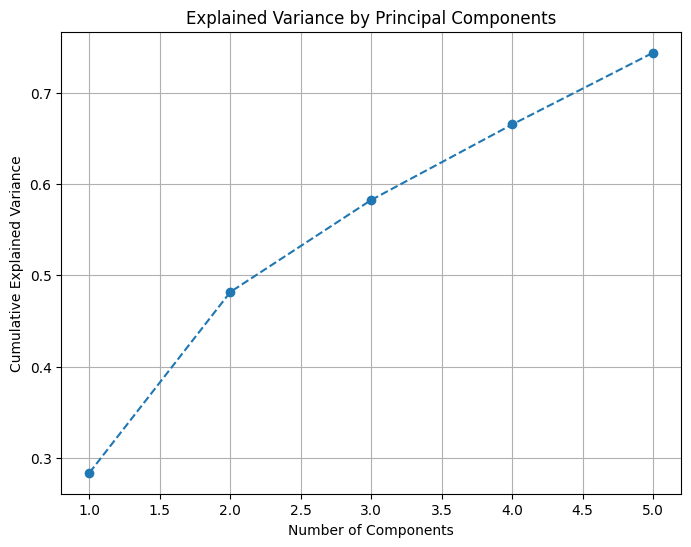

PCA Topic Loadings:
      Employment    Prices  Consumption  Manufacturing  Construction   Lending  \
PC1    0.407581 -0.342198     0.327559       0.346733      0.227705  0.271669   
PC2   -0.024090  0.306701     0.297799       0.200163      0.343969  0.211815   
PC3   -0.289522  0.019654    -0.025139      -0.399419      0.335882  0.512844   
PC4    0.039763 -0.134742     0.070577       0.212334      0.216287 -0.014509   
PC5   -0.192136 -0.232558    -0.218651      -0.183831      0.138745  0.159481   

     Uncertainty  Resources  Transportation   Outlook     Labor   Capital  \
PC1    -0.081782   0.043589       -0.271174  0.148573 -0.372996  0.280062   
PC2     0.404674  -0.104035        0.383784  0.460371  0.256107  0.016975   
PC3    -0.132274  -0.043353       -0.130819  0.071493 -0.131719 -0.436699   
PC4    -0.055871   0.799179        0.168773 -0.184503  0.081883 -0.382365   
PC5     0.544148   0.079579       -0.303758 -0.018516 -0.259530  0.130167   

        Trade  
PC1 -0.204566

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare topic data for PCA
topic_data = aggregated_df[topic_columns]

# Step 2: Standardize the data (important for PCA)
scaler = StandardScaler()
topic_data_scaled = scaler.fit_transform(topic_data)

# Step 3: Perform PCA
n_components = 5  # Adjust the number of components as needed
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(topic_data_scaled)

# Step 4: Create a DataFrame for the principal components
pca_columns = [f"PC{i+1}" for i in range(n_components)]
pca_df = pd.DataFrame(principal_components, columns=pca_columns)
pca_df["DATE"] = aggregated_df["DATE"]  # Include dates for reference

# Step 5: Analyze explained variance
explained_variance = pd.DataFrame({
    "Component": pca_columns,
    "Explained Variance Ratio": pca.explained_variance_ratio_
})
print("Explained Variance by Components:\n", explained_variance)

# Plot cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_components + 1), cumulative_variance, marker="o", linestyle="--")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Principal Components")
plt.grid()
plt.show()

# Step 6: Examine topic loadings
loadings = pd.DataFrame(pca.components_, columns=topic_columns, index=pca_columns)
print("PCA Topic Loadings:\n", loadings)
